In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
from scipy.stats import zscore

In [193]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [276]:
test = pd.read_csv('test.csv')

In [97]:
def timeChange(df):
    df['allot_time'] = pd.to_datetime(df['allot_time'])
    df['accept_time'] = pd.to_datetime(df['accept_time'])
    df['accept_duration'] = df['accept_time'] - df['allot_time']
    df['accept_duration'] = pd.to_timedelta(df['accept_duration']).dt.total_seconds()
    return df

def totalDistance(df):
    df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
    return df

def dropSameValues(df):
    df.drop(['reassignment_method','reassignment_reason','reassigned_order'], axis=1, inplace=True)
    return df

def dropUniqueValues(df):
    df.drop(['order_id','allot_time','accept_time','rider_id'], axis=1, inplace=True)
    return df

def dropNa(df):
    df.dropna(how='any',axis=0, inplace=True)
    return df
    
def order_time(df):
    df['order_time'] = pd.to_datetime(df['order_time'])
    df['order_time'] = pd.Series([val.time() for val in df['order_time']])
    df['order_time'] = pd.Series(val.strftime('%H') for val in df['order_time'])
    df['order_time'] = df['order_time'].astype(int)
    return df

def remove_outlier(df,col):
    df_transactions = df[[col]]
    z_scores = zscore(df_transactions)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = df[filtered_entries]
    return new_df

In [46]:
train = dropUniqueValues(train)

In [27]:
train = totalDistance(train)

In [277]:
test = totalDistance(test)

In [278]:
test = dropSameValues(test)

In [279]:
test = dropUniqueValues(test)

In [280]:
test.drop(['order_time','order_date'],axis=1, inplace=True)

In [211]:
test

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,total_distance
0,1.658500,4.54,216.0,215.0,1.0,747.0,273.400000,6.198500
1,2.070900,5.84,52.0,52.0,0.0,75.0,252.100000,7.910900
2,1.388400,0.99,289.0,289.0,0.0,2214.0,241.383333,2.378400
3,1.903900,2.59,125.0,122.0,3.0,1020.0,291.933333,4.493900
4,0.827500,0.94,352.0,350.0,2.0,7284.0,247.133333,1.767500
...,...,...,...,...,...,...,...,...
144839,1.417000,3.96,52.0,52.0,0.0,413.0,179.266667,5.377000
144840,0.775600,1.61,95.0,93.0,2.0,284.0,244.400000,2.385600
144841,2.049400,1.26,77.0,77.0,0.0,119.0,259.000000,3.309400
144842,0.080494,5.50,231.0,228.0,3.0,1759.0,814.283333,5.580494


In [34]:
train.cancelled.value_counts()

0    444782
1      5218
Name: cancelled, dtype: int64

In [35]:
order_id = test['order_id']

In [43]:
train = timeChange(train)

In [51]:
train.drop(['order_time', 'order_date', 'pickup_time', 'delivered_time','session_time', 'cancelled_time'], axis=1, inplace=True)

<AxesSubplot:>

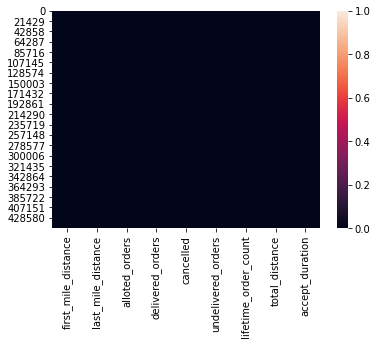

In [59]:
sns.heatmap(train.isna())

In [78]:
allot = train.alloted_orders.median()
delivered = train.delivered_orders.median()
undelivered = train.undelivered_orders.median()

In [79]:
train.alloted_orders.fillna(allot, inplace=True)
train.delivered_orders.fillna(delivered, inplace=True)
train.undelivered_orders.fillna(delivered, inplace=True)

In [117]:
cancelled_1 = train[train.cancelled == 1]

In [118]:
cancelled_0  = train[train.cancelled == 0]

In [119]:
cancelled_0

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,total_distance,accept_duration
0,1.5666,2.65,46.0,46.0,0,0.0,621.0,4.2166,9.0
1,2.5207,2.76,8.0,8.0,0,0.0,105.0,5.2807,48.0
2,2.2074,4.80,1.0,1.0,0,0.0,66.0,7.0074,16.0
3,2.1894,6.38,1.0,1.0,0,0.0,127.0,8.5694,41.0
4,2.7870,4.01,34.0,34.0,0,0.0,84.0,6.7970,36.0
...,...,...,...,...,...,...,...,...,...
449995,0.5789,0.19,4.0,4.0,0,0.0,127.0,0.7689,30.0
449996,1.9863,1.19,81.0,81.0,0,0.0,105.0,3.1763,76.0
449997,1.5944,1.61,28.0,28.0,0,0.0,1488.0,3.2044,33.0
449998,2.8939,4.68,72.0,72.0,0,0.0,105.0,7.5739,142.0


In [181]:
cancelled_1

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,total_distance,accept_duration
20,2.8438,6.81,29.0,29.0,1,0.0,449.0,9.6538,76.0
68,0.8617,2.63,13.0,13.0,1,0.0,168.0,3.4917,83.0
100,2.9217,5.20,118.0,114.0,1,4.0,860.0,8.1217,55.0
163,2.1287,0.45,55.0,52.0,1,3.0,256.0,2.5787,12.0
295,1.6053,4.84,104.0,104.0,1,0.0,3282.0,6.4453,12.0
...,...,...,...,...,...,...,...,...,...
449738,1.7963,2.00,215.0,214.0,1,1.0,975.0,3.7963,38.0
449922,2.2022,2.56,89.0,88.0,1,1.0,176.0,4.7622,64.0
449928,1.6601,7.50,314.0,312.0,1,2.0,437.0,9.1601,39.0
449932,0.9083,8.39,106.0,106.0,1,0.0,133.0,9.2983,NaN


In [185]:
df_1 = cancelled_0.iloc[:88956,:]
df_2 = cancelled_0.iloc[88956:177912,:]
df_3 = cancelled_0.iloc[177913:266868,:]
df_4 = cancelled_0.iloc[266869:355824,:]
df_5 = cancelled_0.iloc[355825:,:]

In [189]:
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(94174, 9)
(94174, 9)
(94173, 9)
(94173, 9)
(94175, 9)


In [309]:
y_1 = df_1['cancelled']
y_2 = df_2['cancelled']
y_3 = df_3['cancelled']
y_4 = df_4['cancelled']
y_5 = df_5['cancelled']

KeyError: 'cancelled'

In [187]:
def dropCancel(df):
    df.drop(['cancelled'],axis=1, inplace=True)
    return df

In [188]:
df_1 = pd.concat([df_1,cancelled_1],axis=0)
df_2 = pd.concat([df_2,cancelled_1],axis=0)
df_3 = pd.concat([df_3,cancelled_1],axis=0)
df_4 = pd.concat([df_4,cancelled_1],axis=0)
df_5 = pd.concat([df_5,cancelled_1],axis=0)

In [292]:
df_1.drop(['cancelled'],axis=1,inplace=True)
df_2.drop(['cancelled'],axis=1,inplace=True)
df_3.drop(['cancelled'],axis=1,inplace=True)

In [293]:
df_4.drop(['cancelled'],axis=1,inplace=True)
df_5.drop(['cancelled'],axis=1,inplace=True)

In [191]:
df_1=(df_1-df_1.mean())/df_1.std()
df_2=(df_1-df_2.mean())/df_2.std()
df_3=(df_1-df_3.mean())/df_3.std()
df_4=(df_1-df_4.mean())/df_4.std()
df_5=(df_1-df_5.mean())/df_5.std()

In [212]:
test = (test-test.mean())/test.std()
test

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,total_distance
0,0.399343,0.924520,1.232923,1.236495,0.186833,-0.053498,0.196427,0.957629
1,0.882993,1.634103,-0.592581,-0.587847,-0.729557,-0.498004,0.082534,1.763732
2,0.082578,-1.013189,2.045495,2.064723,-0.729557,0.916874,0.025232,-0.840660
3,0.687140,-0.139855,0.219991,0.195613,2.019614,0.127082,0.295525,0.155199
4,-0.575229,-1.040480,2.746756,2.747452,1.103224,4.270510,0.055977,-1.128238
...,...,...,...,...,...,...,...,...
144839,0.116119,0.607936,-0.592581,-0.587847,-0.729557,-0.274428,-0.306910,0.570913
144840,-0.636096,-0.674772,-0.113943,-0.128964,1.103224,-0.359757,0.041362,-0.837271
144841,0.857778,-0.865814,-0.314303,-0.308040,-0.729557,-0.468899,0.119429,-0.402397
144842,-1.451295,1.448520,1.399890,1.381994,2.019614,0.615906,3.088561,0.666707


In [249]:
def fillna(df):
    df.lifetime_order_count = df.lifetime_order_count.fillna(df.lifetime_order_count.median())
    df.accept_duration = df.accept_duration.fillna(df.accept_duration.median()) 
    return df

In [250]:
df_1 = fillna(df_1)
df_2 = fillna(df_2)
df_3 = fillna(df_3)
df_4 = fillna(df_4)
df_5 = fillna(df_5)

In [284]:
test.lifetime_order_count = test.lifetime_order_count.fillna(test.lifetime_order_count.median())
test.session_time = test.session_time.fillna(test.session_time.median())

In [285]:
test.isna().sum()

first_mile_distance     0
last_mile_distance      0
alloted_orders          0
delivered_orders        0
undelivered_orders      0
lifetime_order_count    0
session_time            0
total_distance          0
dtype: int64

In [290]:
df_1

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,total_distance,accept_duration
0,0.373485,-0.199957,-0.633253,-0.631711,-0.242193,-0.256307,-0.162219,-0.028583,-0.379730
1,1.483107,-0.142735,-1.060033,-1.061498,-0.242193,-0.256307,-0.499323,0.452320,-0.107844
2,1.118738,0.918478,-1.138650,-1.140669,-0.242193,-0.256307,-0.524802,1.232674,-0.330930
3,1.097804,1.740398,-1.138650,-1.140669,-0.242193,-0.256307,-0.484951,1.938594,-0.156644
4,1.792814,0.507518,-0.768026,-0.767433,-0.242193,-0.256307,-0.513043,1.137587,-0.191501
...,...,...,...,...,...,...,...,...,...
449738,0.640627,-0.538089,1.264795,1.268398,4.128890,-0.194385,0.069050,-0.218530,-0.177558
449922,1.112690,-0.246776,-0.150318,-0.156684,4.128890,-0.194385,-0.452939,0.217992,0.003699
449928,0.482226,2.323025,2.376669,2.376796,4.128890,-0.132463,-0.282427,2.205551,-0.170587
449932,-0.392119,2.786005,0.040610,0.046899,4.128890,-0.256307,-0.481031,2.268008,-0.163616


In [291]:
test

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,total_distance
0,1.658500,4.54,216.0,215.0,1.0,747.0,273.400000,6.198500
1,2.070900,5.84,52.0,52.0,0.0,75.0,252.100000,7.910900
2,1.388400,0.99,289.0,289.0,0.0,2214.0,241.383333,2.378400
3,1.903900,2.59,125.0,122.0,3.0,1020.0,291.933333,4.493900
4,0.827500,0.94,352.0,350.0,2.0,7284.0,247.133333,1.767500
...,...,...,...,...,...,...,...,...
144839,1.417000,3.96,52.0,52.0,0.0,413.0,179.266667,5.377000
144840,0.775600,1.61,95.0,93.0,2.0,284.0,244.400000,2.385600
144841,2.049400,1.26,77.0,77.0,0.0,119.0,259.000000,3.309400
144842,0.080494,5.50,231.0,228.0,3.0,1759.0,814.283333,5.580494


In [282]:
test.alloted_orders.fillna(allot, inplace=True)
test.delivered_orders.fillna(delivered, inplace=True)
test.undelivered_orders.fillna(delivered, inplace=True)

In [286]:
model = XGBClassifier()

In [331]:
preds1 = model.fit(df_1,y_1).predict(test)
preds2 = model.fit(df_2,y_2).predict(test)
preds3 = model.fit(df_3,y_3).predict(test)
preds4 = model.fit(df_4,y_4).predict(test)
preds5 = model.fit(df_5,y_5).predict(test)

[23:59:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [352]:
preds = pd.DataFrame(preds)

In [360]:
preds = pd.DataFrame({'pred1': preds1, 'pred2': preds2, 'pred3': preds3, 'pred4': preds4, 'pred5': preds5})

In [393]:
preds = pd.Series(preds1)

In [361]:
mode = preds.mode(axis=1)

In [394]:
preds.head(100)

0     1
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    1
Length: 100, dtype: int64

In [395]:
ans = pd.concat([order_id,preds], axis=1)

In [357]:
test = pd.read_csv('test.csv')

In [358]:
order_id = test.order_id

In [399]:
ans.rename(columns={0:'cancelled'}, inplace=True)

In [400]:
ans.to_csv('ans8.csv', index=False)

In [401]:
preds.value_counts()

0    112892
1     31952
dtype: int64

In [402]:
ans

,order_id,cancelled
0,130231,1
1,130232,0
2,130233,0
3,130234,0
4,130235,0
...,...,...
144839,41184,0
144840,41185,0
144841,41186,0
144842,41187,1


In [325]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94174 entries, 0 to 449960
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   first_mile_distance   94174 non-null  float64
 1   last_mile_distance    94174 non-null  float64
 2   alloted_orders        94174 non-null  float64
 3   delivered_orders      94174 non-null  float64
 4   undelivered_orders    94174 non-null  float64
 5   lifetime_order_count  94174 non-null  float64
 6   total_distance        94174 non-null  float64
 7   accept_duration       94174 non-null  float64
dtypes: float64(8)
memory usage: 8.5 MB


In [316]:
y_5 = y_5.iloc[1:]
y_5.shape

(94174,)

In [328]:
y_3.loc[len(y_3.index)-1] = 0

In [329]:
y_4.loc[len(y_4.index)-1] = 0

In [330]:
y_3.shape

(94174,)